# **CIS 520: Machine Learning, Fall 2020**
# **Week 13, Worksheet 1**
## Reinforcement Learning


- **Content Creators:** Mihir Parmar
- **Content Reviewers:**  Shaozhe Lyu, Michael Zhou

Learning Objectives:

* Understanding OpenAI's Gym Environment
* Understanding Q-Learning and Sarsa algorithms
* Understanding the differences between off-policy and on-policy algorithms

## 1. OpenAI's Gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or PyTorch.

**We strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) .**

## Exercise 1: 
1. List at least 5 different environments available in the OpenAI gym suite.

## Installing Dependencies and Imports

Let's install gym and some other things to render the environments in Colab.

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py gym[box2d] > /dev/null 2>&1
!pip install piglet > /dev/null 2>&1

In [ ]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
# import tensorflow as tf
# from tensorflow import keras
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os

import matplotlib.animation
import numpy as np
from IPython.display import HTML

# Note, you may get a few warnings regarding Tensorflow and xdpyinfo, these are to be expected

## Q-learning vs SARSA in grid worlds

Firstly, let's gain a bit more intuition for the algorithms we're dealing with by studying them in very simple environments. 

Grid-worlds are simple environments in which an agent navigates a grid, typically aiming to navigate towards goal locations and away from threats. The state variable at its simplest can be a tuple with the agent's location on the grid. 

A more detailed grid world would include the state of the entire grid, like a top-down view of the environment, given as a matrix of $M\times N$ cells.

Here we'll use on- and off-policy TD learning to train an agent to navigate a simple grid world.

This example is based on Example 6.6 of Sutton and Barto. The 'Cliffs' environment implementation comes from [github.com/podondra/gym-gridworlds](https://www.github.com/podondra/gym-gridworlds)

![alt text](https://drive.google.com/uc?id=114P8TIhH4T5hZmoGRhJhBvHLaTZ-ZmWX)

The environment works as follows. Reward is -1 on all transition except those into region that is cliff. Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start. The trial is over when the agent reachs the goal location in the opposite bottom corner.

In [ ]:
!git clone https://github.com/podondra/gym-gridworlds.git
!pip install gym-gridworlds

import gym_gridworlds

Cloning into 'gym-gridworlds'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), done.


In [ ]:
env = gym.make('Cliff-v0')

In [ ]:
print('Number of actions:', env.action_space)
print('Observation space:', env.observation_space)

Number of actions: Discrete(4)
Observation space: Tuple(Discrete(4), Discrete(12))


## Exercise 2: 
1. What do each of the above two variables mean?

Recall that the Q-learning and SARSA algorithms are temporal difference (TD) algorithms. They update their estimate of value based on the difference in a current estimate of value and a once-unrolled-into-the-future estimate of value (which we imagine will be slightly more accurate, since we _know_ what the reward is at the next time step).

The SARSA algorithm is on-policy TD learning:
$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t, a_t))
$$
while Q-learning is off-policy:
$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(r_t + \gamma \max_a Q(s_{t+1},a) - Q(s_t, a_t))
$$

In [ ]:
#Our model parameters
total_episodes = 500
K = 10

#Learning rate
alpha = 0.1
#Discount rate
gamma = 0.95
#Exploration proportion
epsilon = 0.05

ny = 4
nx = 12
n_actions = env.action_space.n

It's quite straightforward to train an agent with either algorithm to solve this Cliff environment.

First, we'll define our policies, based on our estimated Q-values:

In [ ]:
#SARSA learning (on-policy TD learning)
def on_policy(Q, s):
  return np.argmax(Q[s[0], s[1], :])

#Q-learning (off-policy TD learning)
#Epsilon greedy
def off_policy(Q, s, env, epsilon):
  if np.random.random() < epsilon:
    return env.action_space.sample()
  else:
    return np.argmax(Q[s[0], s[1], :])

Now we'll define a simple training loop.

In [ ]:
def train(env, policy, total_episodes = 500, run_test = False, test_freq = 10):
  #Set the agent at starting position
  s = env.reset()
  #Initialize Q values
  Q = np.zeros((ny,nx,n_actions))
  cumulative_reward = 0
  n_episodes = 0
  episode_rewards = []
  test_rewards = []
  #Here an episode only ends once we reach the goal location. 
  #So we're training for 500 successful episodes' worth of experience.
  while n_episodes < total_episodes:
    #Select action given current state
    action = policy(Q, s)
    prev_s = s
    #Step the environment forward
    s, reward, done, _ = env.step(action)
    #Now we have our current state, action, next state and reward
    #So we can take our updates
    future_reward = reward + gamma*np.max(Q[s[0], s[1], :])
    expected_future_reward = Q[prev_s[0], prev_s[1], action]
    Q[prev_s[0], prev_s[1], action] += alpha*(future_reward-expected_future_reward)
    cumulative_reward += reward
    #Reset the agent if we're done. Track rewards
    if done:
      if run_test and n_episodes%test_freq == 0:
        test_r = test(env, on_policy, Q)
        test_rewards.append([n_episodes, test_r])
      s = env.reset()
      episode_rewards.append(cumulative_reward)
      n_episodes += 1
      cumulative_reward = 0

  return episode_rewards, Q

We run this a number of times. This will converge quite quickly since it's such a low dimensional state space, action space, and policy.

In [ ]:
sarsa_rewards = np.zeros((K, total_episodes))
qlearning_rewards = np.zeros((K, total_episodes))
qpolicy = lambda q,s: off_policy(q, s, env, epsilon)

for idx in range(K):
  #Train with SARSA
  rewards, Q_sarsa = train(env, on_policy, total_episodes)
  sarsa_rewards[idx,:] = rewards
  #Train with Q-learning
  rewards, Q_q = train(env, qpolicy, total_episodes)
  qlearning_rewards[idx,:] = rewards

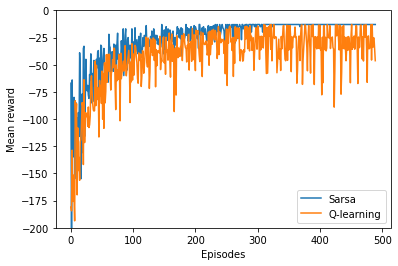

In [ ]:
plt.plot(np.mean(sarsa_rewards[:,10:], 0).T)
plt.plot(np.mean(qlearning_rewards[:,10:], 0).T)
plt.legend(['Sarsa', 'Q-learning'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
plt.ylim([-200,0]);

In [ ]:
def str_policy(policy):
  string = ''
  #char = {0:up, 1:left, 2:down, 3:right}
  #Unicode renders inconsistent sizes in some browsers...
  #char = {0:u"\u25B2", 1:u"\u25B8", 2:u"\u25BC", 3:u"\u25C0"}
  char = {0:"U", 1:"R", 2:"D", 3:"L"}
  for row in policy:
    string += ' '.join([char[action] for action in row]) + '\n'
  return string

In [ ]:
#Plot the policies...
sarsa_policy = np.argmax(Q_sarsa, axis = 2)
print('SARSA policy:\n'+str_policy(sarsa_policy))
q_policy = np.argmax(Q_q, axis = 2)
print('Q-learning policy:\n'+str_policy(q_policy))

SARSA policy:
R L R R L U U R R R D D
U U R R R R R R R R D D
R R R R R R R R R R R D
U U U U U U U U U U U U

Q-learning policy:
R U L U R R R R D U R D
R U R L R L R R R D D D
R R R R R R R R R R R D
U U U U U U U U U U U U



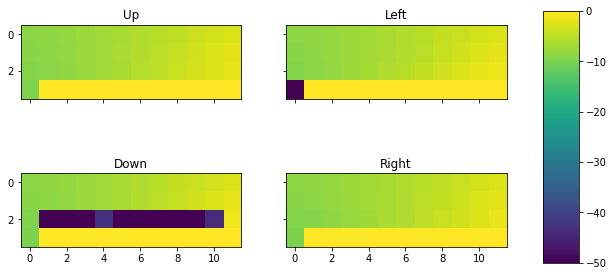

In [ ]:
#We can plot the q values too

#For Q-learning
fig, axes = plt.subplots(2,2, figsize = (10,5), sharex = True, sharey = True)
axes[0,0].imshow(Q_q[:,:,0], vmin=-50, vmax=0)
axes[0,0].set_title('Up')
axes[0,1].imshow(Q_q[:,:,1], vmin=-50, vmax=0)
axes[0,1].set_title('Left')
axes[1,0].imshow(Q_q[:,:,2], vmin=-50, vmax=0)
axes[1,0].set_title('Down')
im = axes[1,1].imshow(Q_q[:,:,3], vmin=-50, vmax=0)
axes[1,1].set_title('Right');

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

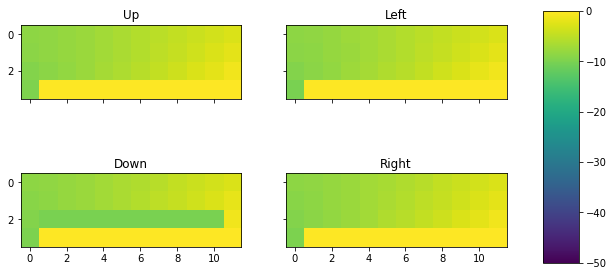

In [ ]:
#For SARSA
fig, axes = plt.subplots(2,2, figsize = (10,5), sharex = True, sharey = True)
axes[0,0].imshow(Q_sarsa[:,:,0], vmin=-50, vmax=0)
axes[0,0].set_title('Up')
axes[0,1].imshow(Q_sarsa[:,:,1], vmin=-50, vmax=0)
axes[0,1].set_title('Left')
axes[1,0].imshow(Q_sarsa[:,:,2], vmin=-50, vmax=0)
axes[1,0].set_title('Down')
im = axes[1,1].imshow(Q_sarsa[:,:,3], vmin=-50, vmax=0)
axes[1,1].set_title('Right');

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

In [ ]:
env.close()

## Exercise 3: 
1. Vary each of the parameters in {number of episodes, discount rate, exloration factor} and observe how the performance/learnt policy changes.

References:
* Towards Data Science: https://towardsdatascience.com/reinforcement-learning-cliff-walking-implementation-e40ce98418d4
* Neuromatch Academy
* CIS 522 Course material